In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

The goal here is to create a recurrent neural network with no inputs whose output is a sine wave.  The approach taken here is to define a differential equation that would trace out a sine wave, then use the nengo software toolkit to create that network, and then extract all the weights of the network so we can run the final model just in normal numpy commands.

The standard differential equation for a linear oscillator of frequency $f$ is

${dx_0 \over dt} = -x_1 2 \pi f \\ {dx_1 \over dt} = -x_0 2 \pi f$

But that oscillator would just oscillate with whatever magnitude of sine wave it starts at.  If it starts at 0,0 then it will just be a sine wave of magnitude 0, which is a straight line.  So we add a component to the differential equation that pushes the magnitude towards 1.

${dx_0 \over dt} = -x_1 2 \pi f + m x_0 * (1-x_0^2-x_1^2) \\ {dx_1 \over dt} = -x_0 2 \pi f  + m x_1 * (1-x_0^2-x_1^2)$

Now we use `nengo` to find connection weights for a network that follows this equation.  For details on how this works, take SYDE 556 or watch this set of videos: https://www.youtube.com/watch?v=w0NxFqIeyZA&list=PLX-XEf1yTMrnjFt30RQ7X6k-dfhL1fIGq.  There are a few parameters for this process:

- `neuron_type` (which we assume to be a Rectified Linear Unit (ReLU) here, for simplicity)
- `n_neurons` (number of neurons)
- `synapse` (the time constant of the reabsorption of the neurotransmitter, which is the dominant term in the dynamics for most neurotransmitters)
- `reg` (amount of regularization to use when finding the connection weights; this is the regularization term for ridge regression, so small values like 1e-10 should lead to very large connection weights and systems that do not generalize well)

The network consists of single layer of recurrently connected neurons (`ens`), all of which are connected to a single output (`output`).

In [2]:
n_neurons = 300
synapse = 0.1
reg = 0.1
dt = 0.001

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=2, neuron_type=nengo.RectifiedLinear(),
                         max_rates=nengo.dists.Uniform(0.5, 1))
    
    def oscillator(x):
        r = 1
        f = 1
        m = 10
        return [
            synapse * (-x[1] * f * 2 * np.pi + m * x[0] * (r - x[0] ** 2 - x[1] ** 2)) + x[0],
            synapse * (x[0] * f * 2 * np.pi + m * x[1] * (r - x[0] ** 2 - x[1] ** 2)) + x[1],
        ]    
    
    c = nengo.Connection(ens, ens, synapse=synapse, function=oscillator,
                         solver=nengo.solvers.LstsqL2(reg=reg))
    output = nengo.Node(None, size_in=1)
    c_out = nengo.Connection(ens, output, synapse=None, function=lambda x: x[0])
    
    p_neurons = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(output)
    
sim = nengo.Simulator(model, dt=dt)
with sim:
    sim.run(3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Here is what that looks like when run with Nengo

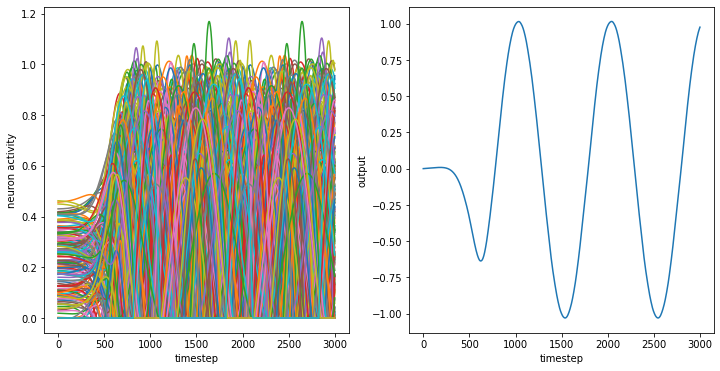

In [3]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(sim.data[p_neurons])
plt.xlabel('timestep')
plt.ylabel('neuron activity')

plt.subplot(1, 2, 2)
plt.plot(sim.data[p_out])
plt.xlabel('timestep')
plt.ylabel('output')
plt.show()


In order to run this ourselves (so that we can then modify the model in various ways), we need to get the various connection weights and neuron parameters out of nengo so that we can simulate them.

In particular, we need:
- `bias`: the constant bias input fed into each neuron
- `w_recurrent`: the recurrent connection weight matrix between each neuron
- `w_output`: the output weights from the neurons to the output.

In [4]:
bias = sim.data[ens].bias
w_recurrent = sim.data[ens].scaled_encoders @ sim.data[c].weights
w_output = sim.data[c_out].weights

We also need to implement a low-pass filter for the synapse model.  For this, we use the standard trick for implementing this assuming timesteps of `dt`:

$y_{k+1} = y_k + \alpha (x_k - y_k)$

where $\alpha$ is $1-e^{dt/\tau}$

In [5]:
alpha = 1-np.exp(-dt/synapse)

Now we can implement our model in normal numpy commands

In [6]:
I_syn = np.zeros(ens.n_neurons)       # initialize the lowpass filter synapse to zero

def rectified_linear(x):              # define the neuron model
    return np.where(x>0, x, 0)

data_out = []                         # for storing our output data
for i in range(3000):
    a = rectified_linear(I_syn)       # the output of the synapse is fed into the neurons to get the neuron activity a
    I = bias + w_recurrent @ a        # compute the total input to the synapse
    I_syn += alpha*(I - I_syn)        # implement the low-pass filter for the synapse
    
    out = w_output @ a                # the output is the neuron activity times the output weights 
    data_out.append(out)              # record the output

And here is the resulting output

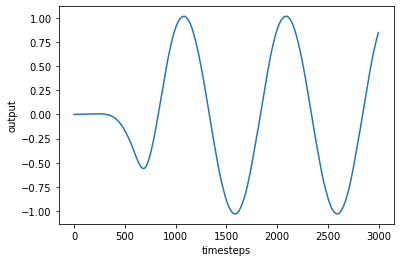

In [7]:
plt.plot(data_out)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()

Note that the output is not exactly the same as in nengo.  That is because nengo initializes the activity of the neurons randomly rather then setting them all to zero.  But the overall behaviour shouldn't depend on this, so we won't worry about it.

Given this model, you can go ahead and change the system in various ways (such as adding noise) and see what happens!